# Assessing the first baroclinic Rossby radius of deformation
__Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute__

#### The project - Havvind

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 6 (?) different farms along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 1x1500MW (430 km²) + 2x2100MW (600km² + 600 km²)
* 258 turbines

### Calculation of mean internal Rossby radius

To investigate the impact of wind farms at sea it is useful to make the study area smaller, i.e. not use the whole model domain. The Rossby radius or deformation radius allows us to delimit the area safely while making sure that the relevant baroclinic dynamics are still within the domain. By taking 1-2 deformation radii as our domain of investigation around the wind farm, we're making sure that the internal dynamics are dominated by internal baroclinic instabilities, and that changes seen are due to interference of wind mills and not other large scale effects. The radius is telling about the length of deformation of a wave, that is a length scale where the rotation of Earth affects the currents and geostrophy dominates.

Sperrevik et al. (2017) calculated the internal Rossby radii using the following method.

$$R_1 = \frac{c_1}{\mid f \mid}$$
where $f$ is the local Coriolis parameter and $c_1$ the phase speed of a first mode baroclinic gravity wave. The phase speed can be solved as an eigenvalue problem, but we will deploy the method of Chelton et al. (1998) and use the WKB-approximation.
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Here, $H$ is the local water depth and $N$ the buoyancy frequency. Sperrevik et al. (2017) calculated the radius for an area in Northern Norway, Lofoten, as shown in the figure below.

<p align="center">
  <img src="Sperrevik_etal_2017_fig5.png" alt="Sperrevik et al. (2017)">
</p>

Here we have the internal deformation radius for the spring months of 1984. The radii has its minimum after the winter and increases towards the summer due to a stronger stratification developing. I will use this figure as a reference to see if the values I compute are reasonable.

Broström (2008) investigated the upper ocean response to disturbances caused by large wind farms, with a focus on the effects due to the wind wake. He found using simple analytical models and idealized numerical experiments that as the wind wake trigger a horizontal gradient in wind stress, the Ekman response is changed due to the curl of the wind stress. More explicitly, upwelling/downwelling velocities exceeding 1 m/day if the characteristic with of the wind wake is of the same size or larger than the internal radius of deformation.

So the further analysis will focus on finding an estimate of the deformation radius of the region around Sørvest F to limit the study area for further analyis, while also comparing the findings to the characteristic length scale of the wind wake.

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid
import xroms
from cartopy import config
from glob import glob
from Rossby_deformation.funcs import *
import matplotlib.style as mplstyle
import cartopy.feature as cfeature

mplstyle.use(['ggplot', 'fast'])

%load_ext autoreload
%autoreload 2

In [3]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [4]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [5]:
# Longitudes and latitudes of the grid
lon = grid.lon_rho
lat = grid.lat_rho

In [6]:
# Finding eta_rho and xi_rho incides of Sørvest midpoints
# Midpoint coordinates found from 'MET_oppdatert_informasjon.pdf'
j_N, i_N = find_indices_of_point(grid, 4.673576935, 57.03354683)  # Turbine cluster North

j_S, i_S = find_indices_of_point(grid, 4.764045976, 56.70158331)  # Turbine cluster South

j_E, i_E = find_indices_of_point(grid, 5.215666154, 56.81933541)  # Turbine cluster East

In [7]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [8]:
R1_roll_7 = R1_rolling_mean_all(files)

Text(0.5, 1.0, 'Rossby deformation radius \n Rolling mean, window = 7 days')

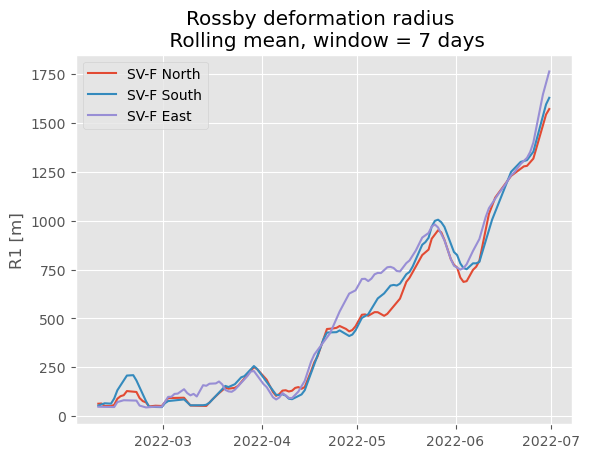

In [9]:
fig, ax = plt.subplots()

ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()
ax.grid(True)

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius \n Rolling mean, window = 7 days')

In [10]:
R1 = extract_R1_all(files)

Text(0.5, 1.0, 'Rossby deformation radius')

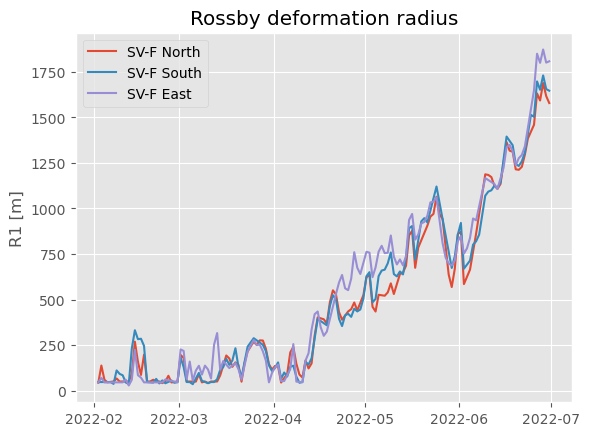

In [11]:
fig, ax = plt.subplots()

ax.plot(R1.ocean_time, R1.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1.ocean_time, R1.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1.ocean_time, R1.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius')

In [12]:
ds_monthly = monthly_mean(files)

Text(0.5, 0.95, 'Monthly mean')

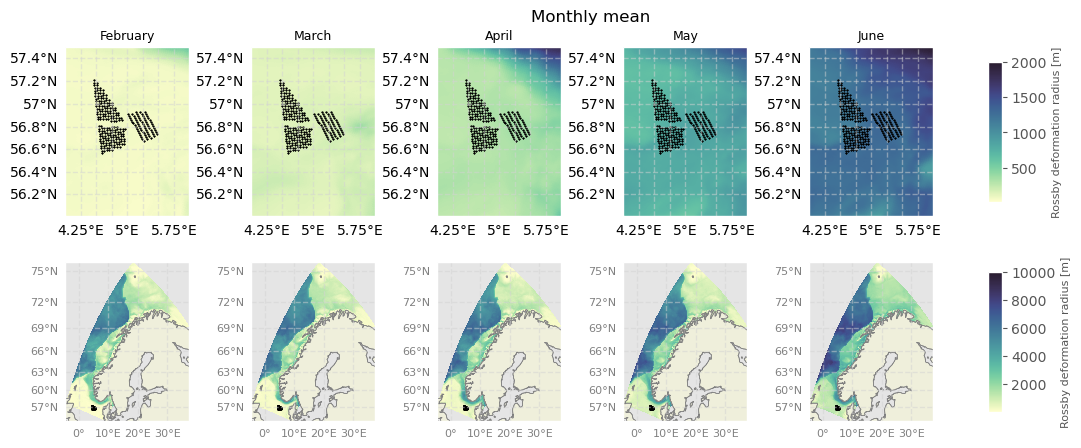

In [13]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(2, 5, figsize=(14, 5), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5)

cmap1 = 'cmo.deep'
cmap2 = 'cmo.deep'
vmin1 = 20
vmax1 = 2000
vmin2 = 20
vmax2 = 10000


for i in range(5):
    axs = ax[0, i]
    axs.set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
    
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, ds_monthly.gamma_r[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap1,
                          vmin=vmin1, vmax=vmax1)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=9)

cbar = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

for i in range(5):
    axs = ax[1, i]
    
    # Plot coordinates
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, ds_monthly.gamma_r[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap2,
                          vmin=vmin2, vmax=vmax2)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i])

    land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
    coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')
    
    axs.add_feature(land)
    axs.add_feature(coastline)


cbar = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

fig.suptitle('Monthly mean', y=0.95)

In [14]:
R1_area_mean = monthly_mean_area(files, grid, [4, 6], [56, 57.5])

In [15]:
# Time mean of the Rossby radius
overall_meantime = ds_monthly.gamma_r.mean(dim='ocean_time')

Text(0.5, 0.98, 'Time mean')

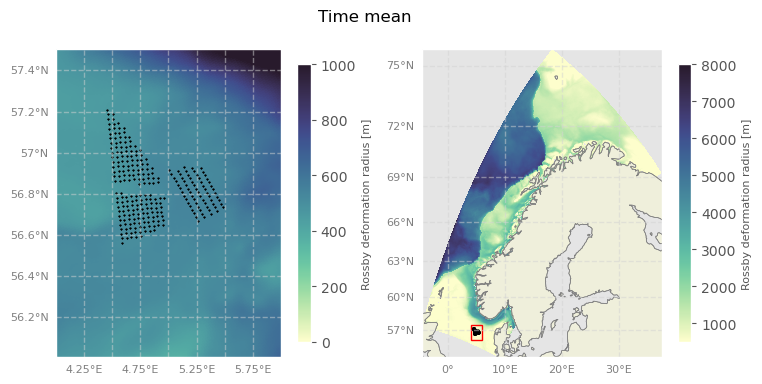

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})
#plt.subplots_adjust(wspace=0.2)

cmap = 'cmo.deep'

ax[0].set_extent([4, 6, 56, 57.5])
pll = ax[0].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

pl = ax[1].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

area_lon = [4, 6, 6, 4]
area_lat = [56, 56, 57.5, 57.5]

ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

ax[1].add_feature(land)
ax[1].add_feature(coastline)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

fig.suptitle('Time mean')

In [17]:
# The monthly mean of the area
R1_area_mon = R1_area_mean.resample(ocean_time='1M').mean(dim='ocean_time')

Text(0.5, 1.0, 'Rossby deformation radius \n Horizontal mean of Sørvest-F region')

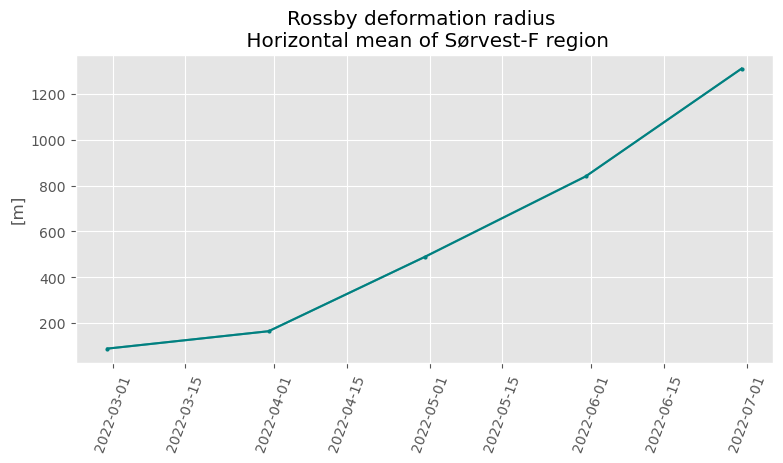

In [18]:
plt.figure(figsize=(9, 4))
plt.plot(R1_area_mean.ocean_time, R1_area_mean.gamma_r, 'teal', alpha=0.6)
plt.plot(R1_area_mon.ocean_time, R1_area_mon.gamma_r, 'teal', marker='o', markersize=2)

plt.xticks(rotation=70)
plt.ylabel('[m]')
plt.title('Rossby deformation radius \n Horizontal mean of Sørvest-F region')

Above I have played around with the calculated Rossby deformation radius. The next step is to use the above to find a specific region around the wind farm to assess. We want the area to be around $4R_1$ to guarantee that the relevant dynamics are within the area.

But the question is, which value of $R_1$ do I choose? We see in the plot above that it has a seasonal cycle due to fresh water input in the spring by snow melt and increased heat input. The freshening and warming of the surface waters towards the summer cause the radius to increase. Comparing the numbers I got to Sperrevik et al. (2017), the deformation scale is somewhat smaller in the region of Sørvest-F. I believe this is caused by distance to land and water depth. The local water depth around the wind farm is quite shallow and it is further away from land. We know that deeper waters and waters which are more stratified hold a larger radius, whereas shallow and less stratified means a shorter radius. 

Now the goal is to limit the model domain to a study area using the deformation radius. Should the study area change with month? Say I use the monthly mean of $R_1$, but then the study area will change with time. If the aim is to limit the area just to assess relevant dynamics, then maybe choosing an area which is big enough for all months would be enough. So take the maximum length? Or the mean of all months?

Another complicating factor is that the wind farm is quite asymmetrical. Say I have decided on a $R_1$ to use, from which point do I make the area? I could guess on a ca midpoint and add $2R_1$ in each direction. But then I would need to convert the distance in meters to change in longitude/latitude, and then find the indices (but that I can do with the function above) to limit the datasets.

Text(0.5, 1.0, 'Ocean bathymetry')

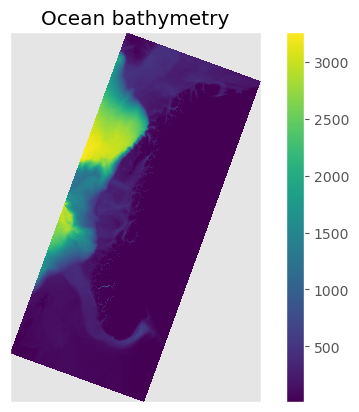

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
im = ax.pcolormesh(lon, lat, grid.h, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im)
ax.set_title('Ocean bathymetry')

In [20]:
print(f'Water depth at Sørvest-F north: {grid.h[j_N, i_N]:.2f}m, south: {grid.h[j_S, i_S]:.2f} m, east: {grid.h[j_E, i_E]:.2f}m')

Water depth at Sørvest-F north: 63.68m, south: 59.89 m, east: 57.47m


If we take 4 times the monthly mean of R1 within the area (which I chose a bit randomly):

In [21]:
R1_4_area = R1_area_mon.gamma_r.values*4

Then $4R_1$ of the June mean is 4-88 times larger than $R_1$ for the rest of the months

In [22]:
R1_4_area[-1]/R1_area_mon.gamma_r.values[0]

58.965995360541456

So, as a first approach let's try to make a study area which is $4R_1(June)$ x $4R_1(June)$

My thought is to use a midpoint of the area of turbines (a midpoint between all three clusters) and then add $2R_1$ in all directions.

In [23]:
# Guessing on a midpoint of the wind farm
mid_lat = 56.8
mid_lon = 5.0

j_mid, i_mid = find_indices_of_point(grid, mid_lon, mid_lat)

In [24]:
# Meters to add in each direction from midpoint
R1_2_dist = R1_4_area[-1]/2

In [25]:
east_lon, west_lon, north_lat, south_lat = move_distance_from_point(mid_lon, mid_lat, R1_2_dist)

In [26]:
area_lon = [west_lon, east_lon]
area_lat = [south_lat, north_lat]

In [27]:
ds_studyarea = make_region_ds(files, grid, area_lon, area_lat)

Text(0.5, 0.98, 'Time mean of Rossby deformation radius \n Study area')

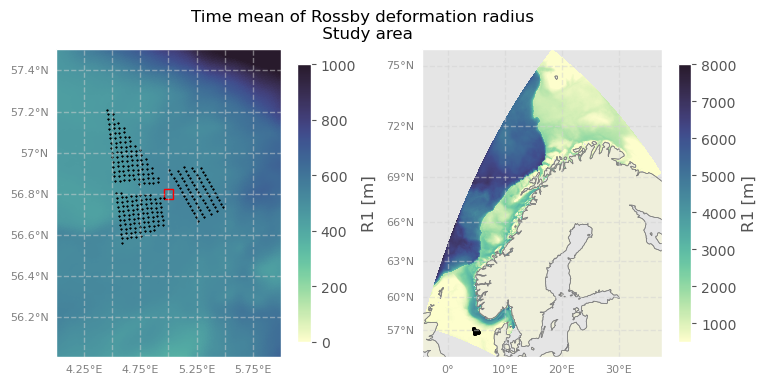

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})
#plt.subplots_adjust(wspace=0.2)

cmap = 'cmo.deep'

ax[0].set_extent([4, 6, 56, 57.5])
pll = ax[0].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [west_lon, east_lon, east_lon, west_lon]
area_lat = [south_lat, south_lat, north_lat, north_lat]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

ax[1].add_feature(land)
ax[1].add_feature(coastline)

fig.suptitle('Time mean of Rossby deformation radius \n Study area')

As we see, and kinda expected, this does not make any sense. The wind farm is huge, and has 2.5 km distance between each turbine. Thus, with such low values of the Rossby deformation radius in the area, trying to use 4-7 times the radius as a area limitation does not make sense.

Maybe I have misunderstood something cruical though... But the red box in the plot above is a region measuring $4R_1$ x $4R_1$, where the $R_1$ used is the June mean, aka largest of the time series. 

Even though I cant use this to limit the study area here, for other wind farms along the coast where the Rossby radius might be larger, the approach could be useful. What this is telling me, if everything above is correct, is that we can choose an arbitrary study area around Sørvest-F because we are guaranteed that baroclinic dynamics are resolved (?). At least, the study area can practically not become too small. 

However, the problem is still unanswered. Which region should we limit the study area to, to be able to assess the impacts of the wind farm? For the sake of progress I will choose a region randomly, but have in mind that at least its way bigger than the internal Rossby deformation radius.

A new thought popped up. Dear diary... :)

All of the above calculations was done on data from the reference runs - the control runs without turbines. An eduacated guess would be that the turbines, due to the wind wake and altercations in surface stress and hence mixing, might change the stratification in the area as well. This in turn could affect the Rossby deformation radius! Weaker surface stress -> less vertical mixing -> stronger stratification -> larger radius. However, at the current moment I dont know WHERE the wind wake is, as it depends on the wind direction. Does it work to just use points within the turbines, as the midpoints of north, south, east? Or would the stress be reduced some location after the park...

Therefore, before moving on, I will check what the Rossby radii from the experiment data looks like.

In [29]:
filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_bdr/EXP')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/EXP_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [30]:
R1_exp = extract_R1_all(files)

Text(0.5, 1.0, 'Rossby deformation radius - EXP')

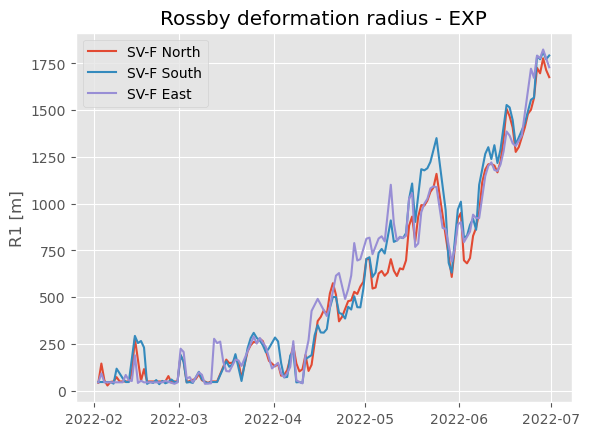

In [31]:
fig, ax = plt.subplots()

ax.plot(R1_exp.ocean_time, R1_exp.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1_exp.ocean_time, R1_exp.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1_exp.ocean_time, R1_exp.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius - EXP')

In [32]:
exp_mon = R1_exp.resample(ocean_time='1M').mean(dim='ocean_time')

In [33]:
ref_exp_mon_diff = ds_monthly.gamma_r - exp_mon

Text(0.5, 0.95, 'Difference in Rossby radius of deformation - REF-EXP')

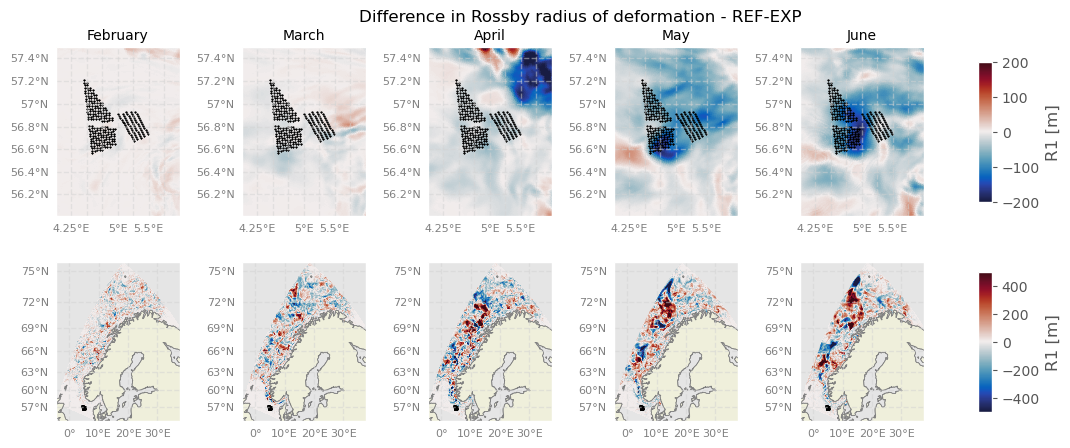

In [53]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(2, 5, figsize=(14, 5), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5)

cmap1 = 'cmo.balance'
cmap2 = 'cmo.balance'
vmin1 = -200
vmax1 = 200
vmin2 = -500
vmax2 = 500


for i in range(5):
    axs = ax[0, i]
    axs.set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
    
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, ref_exp_mon_diff[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap1,
                          vmin=vmin1, vmax=vmax1)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=10)

cbar = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('R1 [m]')

for i in range(5):
    axs = ax[1, i]
    
    # Plot coordinates
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, ref_exp_mon_diff[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap2,
                          vmin=vmin2, vmax=vmax2)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i])

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)


cbar = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('R1 [m]')

fig.suptitle('Difference in Rossby radius of deformation - REF-EXP', y=0.95)

In [35]:
relative_diff_R1 = (ref_exp_mon_diff/ds_monthly.gamma_r)*100

Text(0.5, 0.95, 'Percentage difference in Rossby radius of deformation - (REF-EXP)/REF')

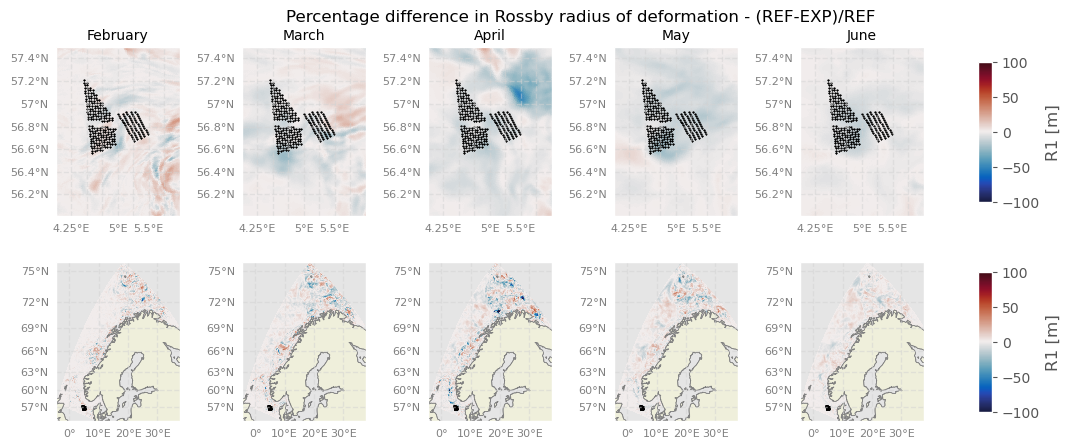

In [51]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(2, 5, figsize=(14, 5), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5)

cmap1 = 'cmo.balance'
cmap2 = 'cmo.balance'
vmin1 = -100
vmax1 = 100
vmin2 = -100
vmax2 = 100


for i in range(5):
    axs = ax[0, i]
    axs.set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
    
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, relative_diff_R1[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap1,
                          vmin=vmin1, vmax=vmax1)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=10)

cbar = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('R1 [m]')

for i in range(5):
    axs = ax[1, i]
    
    # Plot coordinates
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(lon, lat, relative_diff_R1[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap2,
                          vmin=vmin2, vmax=vmax2)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i])

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)

cbar = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('R1 [m]')

fig.suptitle('Percentage difference in Rossby radius of deformation - (REF-EXP)/REF', y=0.95)

In [37]:
R1_area_mean_exp = monthly_mean_area(files, grid, [4, 6], [56, 57.5])

In [38]:
overall_meantime_exp = exp_mon.mean(dim='ocean_time')

In [39]:
overall_meantime_diff = overall_meantime - overall_meantime_exp

Text(0.5, 0.98, 'Difference in time mean of Rossby deformation radius, REF-EXP')

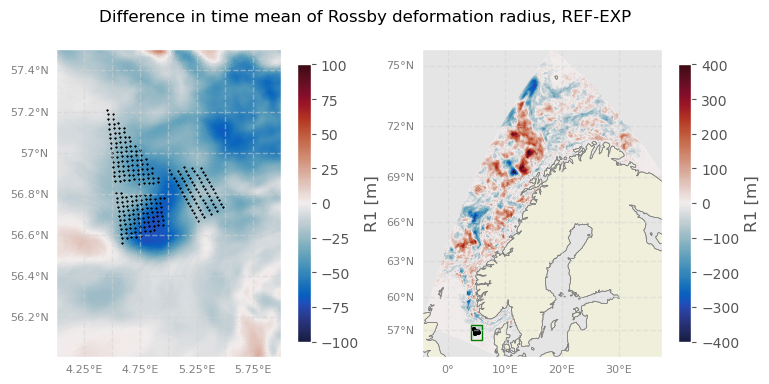

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})
#plt.subplots_adjust(wspace=0.2)

cmap = 'cmo.balance'

ax[0].set_extent([4, 6, 56, 57.5])
pll = ax[0].pcolormesh(lon, lat, overall_meantime_diff, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-100, vmax=100)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, overall_meantime_diff, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-400, vmax=400)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [4, 6, 6, 4]
area_lat = [56, 56, 57.5, 57.5]

ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='green', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

ax[1].add_feature(land)
ax[1].add_feature(coastline)

fig.suptitle('Difference in time mean of Rossby deformation radius, REF-EXP')

In [41]:
R1_area_mon_exp = R1_area_mean_exp.resample(ocean_time='1M').mean(dim='ocean_time')

Text(0.5, 1.0, 'Rossby deformation radius \n Horizontal mean of Sørvest-F region')

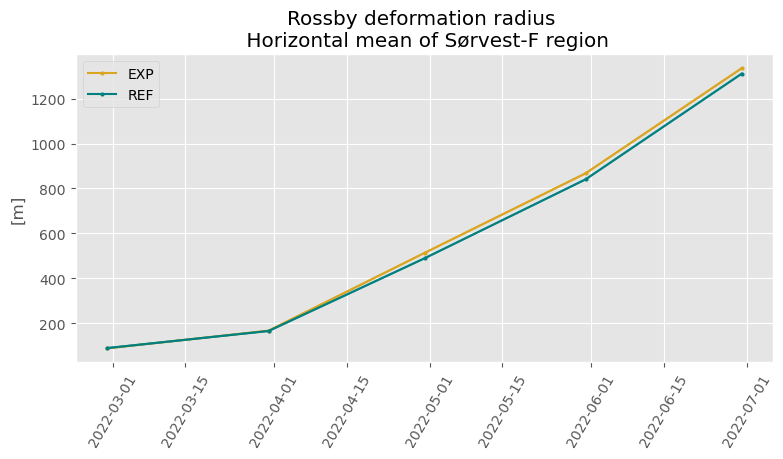

In [54]:
plt.figure(figsize=(9, 4))
plt.plot(R1_area_mean_exp.ocean_time, R1_area_mean_exp.gamma_r, 'goldenrod', alpha=0.6)
plt.plot(R1_area_mon_exp.ocean_time, R1_area_mon_exp.gamma_r, 'goldenrod', marker='o', markersize=2, label='EXP')

plt.plot(R1_area_mean.ocean_time, R1_area_mean.gamma_r, 'teal', alpha=0.6)
plt.plot(R1_area_mon.ocean_time, R1_area_mon.gamma_r, 'teal', marker='o', markersize=2, label='REF')

plt.xticks(rotation=60)
plt.legend()
plt.ylabel('[m]')
plt.title('Rossby deformation radius \n Horizontal mean of Sørvest-F region')

In [43]:
area_diff_through_time = R1_area_mean - R1_area_mean_exp

Text(0.5, 1.0, 'Difference in horizontal mean of R1 (REF-EXP)')

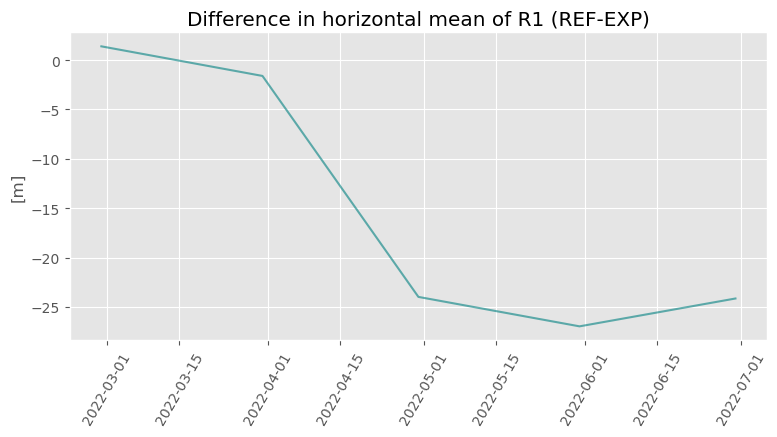

: 

In [ ]:
plt.figure(figsize=(9, 4))
plt.plot(area_diff_through_time.ocean_time, area_diff_through_time.gamma_r, 'teal', alpha=0.6)
plt.ylabel('[m]')
plt.xticks(rotation=60)
plt.title('Difference in horizontal mean of R1 (REF-EXP)')

In [45]:
R1_4_area

array([ 355.67750034,  659.14889653, 1954.43351842, 3361.59822231,
       5243.21945872])

New approach: I will try to make a ploygon/square around the wind park and from there add the radius toe xapnd the area. Switchin to a different notebook: `making_study_area.ipynb`.